In [1]:
from neuralforecast.models import NHITS, HEncoder, PatchTST, MIXModel
from neuralforecast.losses.pytorch import MAE
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info
from neuralforecast import NeuralForecast
import pandas as pd

input_size = 512
horizon = 336
dataset = "ETTh1"
exp_flag = 'model_structure_test'

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
train_df = Y_df[:-test_size]
test_df = Y_df[-test_size:]

epochs = 100

hencoder = HEncoder(
    h=horizon,
    input_size=input_size,
    max_steps=epochs,
    exclude_insample_y=False,
    stat_exog_list=None,
    hist_exog_list=None,
    futr_exog_list=None,
    decoder_dropout = 0.,
    decomp_kernel_size = 25,
    
    ### MLP:
    mlp_hidden_size = 128,
    mlp_stacks = 3,
    mlp_blocks = 1,  
    mlp_block_layers = 1, 
    n_pool_kernel_size = [2, 2, 1],
    n_freq_downsample=[4, 2, 1],  
    mlp_pooling_mode = "MaxPool1d",
    mlp_interpolation_mode = "linear",
    mlp_dropout=0.0,
    mlp_activation = "ReLU",

    ### former:
    former_input_size = 96,
    former_encoder_layers = 1,
    former_heads = 4,
    former_hidden_size = 64,
    former_linear_size = 256,
    former_dropout = 0.3,
    fc_dropout = 0.0,
    head_dropout = 0.0,
    attn_dropout = 0.0,
    former_patch_len = 16,
    former_stride = 8,
    revin = False,
    revin_affine = False,
    revin_subtract_last = True,
    former_activation = "gelu",
    res_attention = True,
    batch_normalization = True,
    learn_pos_embed = True,
    
    ### basics:
    loss=MAE(),
    valid_loss=None,
    learning_rate = 1e-3,
    num_lr_decays = 3,
    early_stop_patience_steps = -1,
    val_check_steps = 100,
    batch_size = 32,
    valid_batch_size = None,
    windows_batch_size=64,
    inference_windows_batch_size = -1,
    step_size = 1,
    scaler_type = "identity",
    random_seed = 1,
    num_workers_loader = 0,
    drop_last_loader = False,
)

nhits = NHITS(
    h=horizon,
    input_size=input_size,
    max_steps=epochs,
    exclude_insample_y=False,
    stat_exog_list=None,
    hist_exog_list=None,
    futr_exog_list=None,
    stack_types = ["identity", "identity", "identity"],  
    n_blocks = [3, 3, 3],
    mlp_units = 3 * [[512, 512]],
    n_pool_kernel_size = [2, 2, 1],
    n_freq_downsample = [4, 2, 1],
    pooling_mode = "MaxPool1d",
    interpolation_mode = "linear",
    dropout_prob_theta=0.0,
    activation="ReLU",
    
    loss=MAE(),
    valid_loss=None,
    learning_rate = 1e-3,
    num_lr_decays = 3,
    early_stop_patience_steps = -1,
    val_check_steps = 100,
    batch_size = 32,
    valid_batch_size = None,
    windows_batch_size = 64,
    inference_windows_batch_size = -1,
    step_size = 1,
    scaler_type = "identity",
    random_seed = 1,
)

patchtst = PatchTST(
    h=horizon,
    input_size=input_size,
    max_steps=epochs,
    exclude_insample_y=False,
    stat_exog_list=None,
    hist_exog_list=None,
    futr_exog_list=None,
    
    encoder_layers = 1,
    n_heads = 4,
    hidden_size = 64,
    linear_hidden_size = 256,
    
    loss=MAE(),
    valid_loss=None,
    learning_rate = 1e-3,
    num_lr_decays = 3,
    early_stop_patience_steps = -1,
    val_check_steps = 100,
    batch_size = 32,
    valid_batch_size = None,
    windows_batch_size = 64,
    inference_windows_batch_size = -1,
    step_size = 1,
    scaler_type = "identity",
    random_seed = 1,
)

nf = NeuralForecast(models=[hencoder, nhits, patchtst], freq=freq)
nf.fit(df=train_df, val_size=val_size)
pred_df = nf.predict(df=test_df[:-input_size])

d:\code\env\hencoder\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 1


RuntimeError: HEncoder is not attached to a `Trainer`.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
results = pd.merge(test_df, pred_df, on="ds", how="outer")
resultdir:str = 'exp_results'
filename: str = exp_flag+'_'+dataset+'_'+str(horizon)+"_results.csv"
results.to_csv(os.path.join(resultdir,filename), index=False)

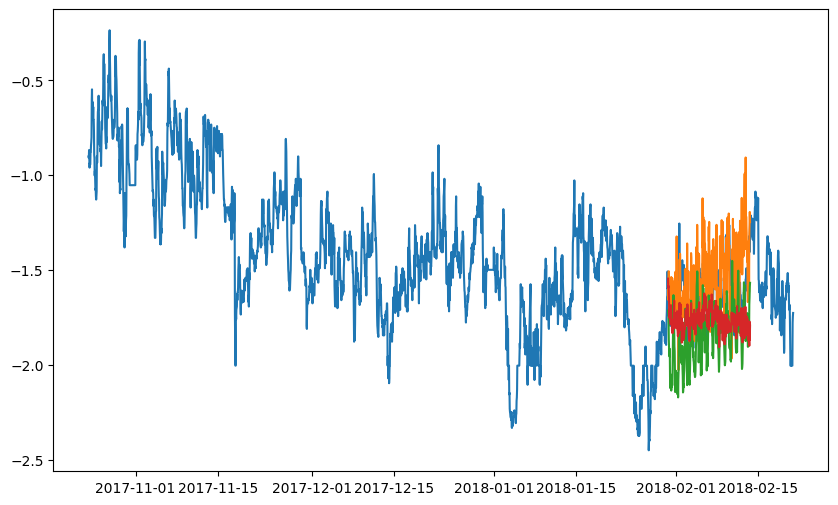

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pred_df = pd.read_csv('./exp_results/compare_mlp_ETTh1_336_results.csv', index_col='index')
pred_df["ds"] = pd.to_datetime(pred_df["ds"])

plt.figure(figsize=(10, 6))
plt.plot(pred_df['ds'],pred_df["y"].values)
plt.plot(pred_df['ds'],pred_df['HEncoder'].values)
plt.plot(pred_df['ds'],pred_df['NHITS'].values)
plt.plot(pred_df['ds'],pred_df['PatchTST'].values)


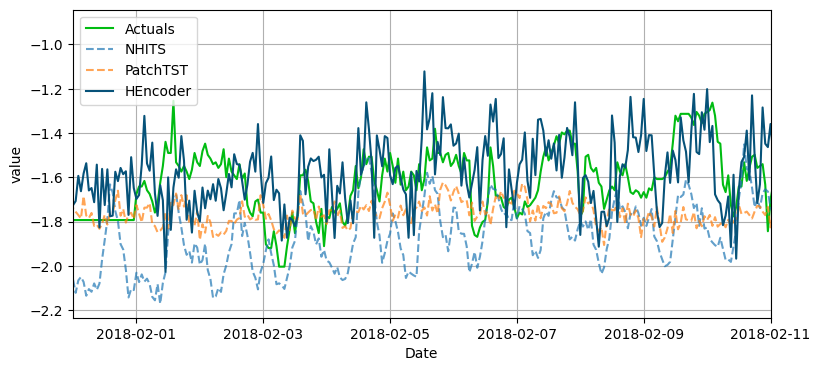

In [ ]:
from datetime import datetime
pred_df = pred_df.dropna()
plt.figure(figsize=(9, 4))
plt.grid(True)
plt.plot(pred_df['ds'],pred_df['y'].values, label='Actuals', color='#00BC12')
plt.plot(pred_df['ds'],pred_df['NHITS'].values, label='NHITS',linestyle='--',alpha=0.7)
plt.plot(pred_df['ds'],pred_df['PatchTST'].values, label='PatchTST',linestyle='--',alpha=0.7)
plt.plot(pred_df['ds'],pred_df['HEncoder'].values, label='HEncoder', color='#065279')


plt.xlim(datetime(2018,1,31),datetime(2018,2,11))
ticks, _ = plt.xticks()
plt.xticks(ticks[1:])
plt.legend()
plt.xlabel('Date')
plt.ylabel('value')
plt.show()

In [ ]:
from neuralforecast.losses.numpy import mae, mse
print("MSE: ", mse(pred_df['y'], pred_df['HEncoder']))
print("MAE: ", mae(pred_df['y'], pred_df['HEncoder']))

MSE:  0.045204203619509685
MAE:  0.17073101250360564
